# seismic petrophysics

With this notebook I show how to create a synthetic dataset of elastic properties (Vp, Vs, density, etc.) starting from well logs. The idea is that the wells cannot possibly sample all the complexity and variations occurring across a reservoir. So what I do is to use various techniques to synthesize new data and create an _abstraction_ of my reservoir to investigate alternative and plausible scenarios (change of pore fluids; lithological variations); another possible use of is to create a training dataset to calibrate 3D seismic volumes (see also the discussion on _training data_ in Avseth et al., 2005, p.126).

What I also want to do is to demonstrate the use of Python to build your own tools and workflows and therefore move away from a "[black-box](http://en.wikipedia.org/wiki/Black_box) approach".

This material was featured in the Geophysical Tutorial columns in the [April](http://library.seg.org/doi/abs/10.1190/tle34040440.1) and [June 2015](http://library.seg.org/doi/abs/10.1190/tle34060700.1) issues of The Leading Edge.

_Alessandro, April 2015_

**History:**
- November 2014 - April 2015: first version.
- January 2016: fixed various bugs related to newer version of Pandas, rewritten explanations in the statistical analysis section.
- June 2018: removed deprecated Pandas methods (e.g., `.ix`), plus various other small corrections.

**To-do:**
- check the warning message in `np.random.multivariate_normal` about covariance not positive-semidefinite.

## the plan

The idea is to show how to do these things:

* import well log data and create a new lithology curve log;
* data augmentation through fluid-replacement modeling; 
* description of the reservoir complex under study through statistical analysis;
* creation of a synthetic dataset to replicate the overall behaviour of the reservoir complex.

And while doing this, I will also show some cool features of Python, such as using the Pandas library to explore geophysical data, defining evergreen functions like Gassmann and Voigt-Reuss-Hill, do fancy plots and make interactive tools.

## input data

The well log I will use is part of the test datasets available on the Quantitative Seismic Interpretation book website:

<https://srb.stanford.edu/quantitative-seismic-interpretation>

In particular, I use "Well 2", contained in the "Project Data" zipfile. Plenty of background information for this particular well is available on Per Avseth's PhD thesis, again available from the Stanford website:

<https://srb.stanford.edu/theses>

The actual file I will use in this notebook, `qsiwell2.csv` is an elaboration of several other files contained in that zip archive (merged some logs, created others, etc.). See `qsiwell2_dataprep.py` in the [repo](https://github.com/aadm/geophysical_notes) for details.

## coding in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

First a few words on the libraries I am using:

* numpy
* matplotlib
* pandas

Note the use of the [Pandas](http://pandas.pydata.org/index.html) library to digest log data; it's a library built to handle big datasets and make your life easier (as we shall see later). This is *my* way to do things. You are welcome to use Python's built-in structures if you're inclined to do so or need to keep things minimal (Matt and Evan at [Agile Geoscience](http://www.agilegeoscience.com) do [wonderful things](https://github.com/agile-geoscience/notebooks) relying on the standard triumvirate numpy/scipy/matplotlib).

For those interested in using their own `.las` files, there is another library (<http://wiki.scipy.org/Cookbook/LASReader>) that can be used.

## data loading with Pandas

Let's load `qsiwell2.csv` into the [Pandas DataFrame](http://pandas.pydata.org/pandas-docs/dev/dsintro.html#dataframe) `L`:

In [2]:
L=pd.read_csv('qsiwell2.csv', index_col=0)

to check what's now inside `L`:

In [3]:
L.columns

Index(['VP', 'VS', 'RHO_OLD', 'GR', 'NPHI', 'RHO', 'SWE', 'SWX', 'VPVS', 'IP',
       'IS', 'VSH', 'RHOm', 'RHOf', 'PHIE'],
      dtype='object')

As you can see, I have all the required logs for a quantitative analysis: the elastic logs (compressional and shear velocity `Vp` and `Vs`, density `RHO`) as well as the main petrophysical logs (water saturation `Sw`, shale volume `VSH` and porosity `PHI`).

Logs stored into a Pandas DataFrame are easily accessed using the syntax `DataFrame.log` or `DataFrame['log']`, e.g. `L.VP` is the P-wave velocity and `L['PHIE']` is effective porosity.

To select more than one log, use the syntax `DataFrame[['log1','log2']]`. Mix and match with filters such as `DataFrame.index>2100` to restrict the data only to those values below 2100m and you can get all the information you need:

In [4]:
print('Average Ip between 1500 and 2000 m:')
print(L[(L.index>=2100) & (L.index<2200)][['VP','RHO']].mean())

Average Ip between 1500 and 2000 m:
VP     2551.785823
RHO       2.216325
dtype: float64


If I had a [categorical variable](http://en.wikipedia.org/wiki/Categorical_variable), for example a litho-facies log like the `LFC` (litho-fluid class) log that I will show later on in this notebook, I could use the syntax `DataFrame[DataFrame.LFC==2]['log1','log2']]` to only select data belonging to a specific class.

To remove a specific log (e.g., that `RHO_OLD`) I use the `drop` method with the optional `axis=1` (required otherwise Pandas will search for a _row_ named `TVD` instead of a _column_):

In [5]:
L=L.drop(['RHO_OLD'],axis=1)

Let's check if I have really deleted `RHO_OLD`:

In [6]:
L.columns

Index(['VP', 'VS', 'GR', 'NPHI', 'RHO', 'SWE', 'SWX', 'VPVS', 'IP', 'IS',
       'VSH', 'RHOm', 'RHOf', 'PHIE'],
      dtype='object')

To rename a log use the `.rename` method:

In [7]:
L.rename(columns={'RHOf':'RHOfluid'}, inplace=True)
L.columns

Index(['VP', 'VS', 'GR', 'NPHI', 'RHO', 'SWE', 'SWX', 'VPVS', 'IP', 'IS',
       'VSH', 'RHOm', 'RHOfluid', 'PHIE'],
      dtype='object')

But what if I need to rename multiple logs? Simply assign a new list of names to the DataFrame columns; for example, if I have a 3 logs called `log1`, `log2`, `log3`, I can rename them all in one go using this syntax:

    DataFrame.columns=['newlog1','newlog2','newlog3']
    
Pandas is the best way I have ever seen to manage large and complex datasets;  the basic Dataframe is a compact, portable and powerful data structure that allows you to quickly inspect your data, either using standard Python functions (like `min()`, `.max()`, `.mean()`) or the `describe` method:

In [8]:
print('Depth min/max: {:.1f}/{:.1f}'.format(L.index.min(),L.index.max()))
print('Vp average: {:.2f}'.format(L.VP.mean()))

Depth min/max: 2013.3/2640.5
Vp average: 2977.10


In [9]:
L[['VP','VS','RHO','PHIE']].describe()

,VP,VS,RHO,PHIE
count,4117.000000,4117.000000,2701.000000,2701.000000
mean,2977.098761,1371.293952,2.225045,0.291759
std,449.355552,297.056552,0.061961,0.032196
min,1439.900000,688.800000,2.036616,0.106844
25%,2594.500000,1141.600000,2.185285,0.276218
50%,3036.100000,1415.300000,2.223544,0.297311
75%,3251.100000,1595.000000,2.264000,0.310519
max,4431.000000,2427.800000,2.545268,0.376396


## litho-fluid class logs

The next step is to calculate a _Litho-Fluid Class_ log (LFC), where I separate groups of data identified by similar lithological and/or pore fluid content. The values of the LFC log will be assigned following these rules:

* LFC=0: undef
* LFC=1: brine sand
* LFC=2: oil sand
* LFC=3: gas sand
* LFC=4: shale

First I restrict my analysis on a smaller depth window (first line in the code snippet below) because the petrophysical logs are not computed everywhere. Then I create the "flag" logs `ssb`, `sso`, `ssg` and `sh`  (i.e., logs made of samples that can only be 1 or 0, i.e. _True_ or _False_) using cut-off values on `VSH` (shale volume) and `SW` (water saturation): 

In [10]:
L=L[(L.index>=2100) & (L.index<=2400)]

sand_cutoff=0.20
ssb=((L.VSH <= sand_cutoff) & (L.SWE >= 0.9)) # brine sand
sso=((L.VSH <= sand_cutoff) & (L.SWE < 0.9))  # oil sand
sh=(L.VSH > sand_cutoff)                      # shales

Notice that there is no `ssg` log (occurrence of gas sands) yet, as the insitu log did not record any gas sand. We will deal with that later.

I use the above flag logs to create the `LFC` log and store it into `L` with the other logs:

In [11]:
temp_lfc=np.zeros(np.shape(L.VSH))
temp_lfc[ssb.values]=1    # LFC will be 1 when ssb (brine sand flag) is True
temp_lfc[sso.values]=2    # LFC will be 2 when sso (oil sand flag) is True
temp_lfc[sh.values]=4     # LFC will be 4 when sh (shale flag) is True
L.insert(L.columns.size, 'LFC', temp_lfc) # the first argument is the position, in this way LFC will be the last one.

Now, let's see if this is all ok; the total number of samples after zooming in the 2100-2400 m depth window is:

In [12]:
np.shape(L.VSH)

(1968,)

and the following prints out how many samples each facies is made of:

In [14]:
print('brine sst={}, oil sst={}, shale={}'.format(np.count_nonzero(ssb),np.count_nonzero(sso),np.count_nonzero(sh)))

brine sst=706, oil sst=134, shale=1128


And a final check to make this newly defined `LFC` log only has values within the range 1 to 4 (there will be no undefined samples in this particular depth interval, i.e. classes with `LFC=0`):

In [16]:
print('LFC min: {}, LFC max: {}'.format(L.LFC.min(), L.LFC.max()))

LFC min: 1.0, LFC max: 4.0


It is very easy to do plots of all types with Pandas, and to show that here's a one-liner that plots Vp histograms for each class (remember that at this point we only have classes 1, 2 and 4, i.e. brine sand, oil sand and shales):

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0dc877d2b0>,
      dtype=object)

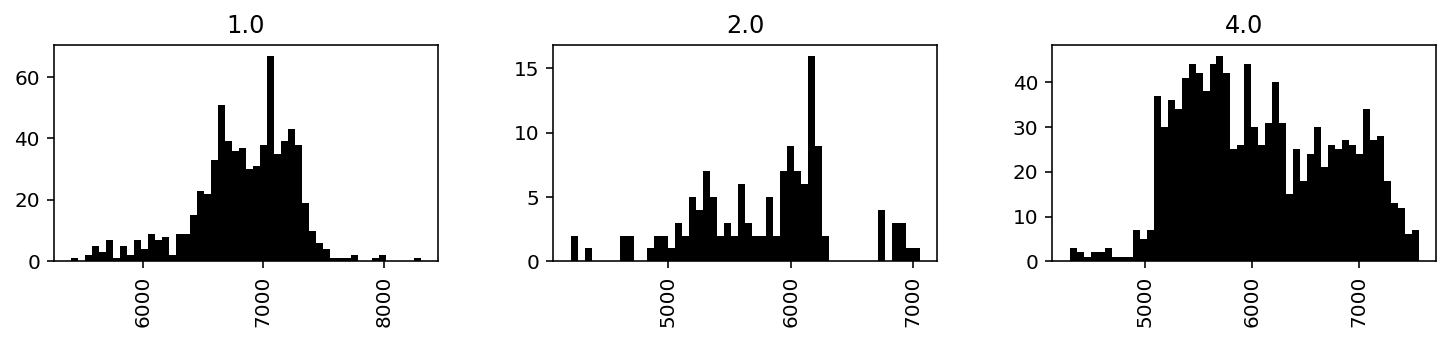

In [17]:
L.IP.hist(bins=50, color='black', by=L.LFC, figsize=(12,2), layout=(1,3), lw=0)

## summary plots

First I need a custom colormap for my classes, i.e. a discrete colormap with following classes-colors association:

* LFC=0: undef, GRAY
* LFC=1: brine sand, BLUE
* LFC=2: oil sand, GREEN
* LFC=3: gas sand, RED
* LFC=4: shale, BROWN

This is the way to define this colormap:

In [18]:
import matplotlib.colors as colors
#      0=undef   1=bri  2=oil   3=gas 4=shale
ccc = ['#B3B3B3','blue','green','red','#996633',]
cmap_facies = colors.ListedColormap(ccc[0:len(ccc)], 'indexed')

Let's now display a summary view of all the logs:

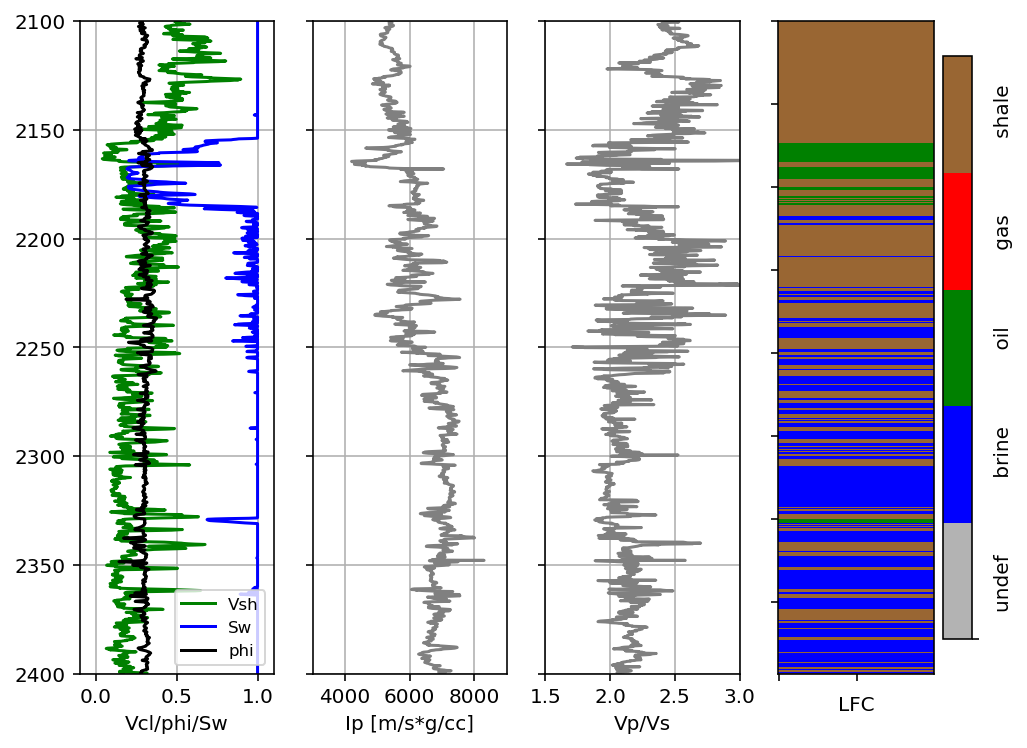

In [19]:
ztop=2100; zbot=2400
ll=L[(L.index>=ztop) & (L.index<=zbot)]

cluster=np.repeat(np.expand_dims(ll['LFC'].values,1),100,1)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 6))
ax[0].plot(ll.VSH, ll.index, '-g', label='Vsh')
ax[0].plot(ll.SWE, ll.index, '-b', label='Sw')
ax[0].plot(ll.PHIE, ll.index, '-k', label='phi')
ax[1].plot(ll.IP, ll.index, '-', color='0.5')
ax[2].plot(ll.VPVS, ll.index, '-', color='0.5')
im=ax[3].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=4)
cbar=plt.colorbar(im, ax=ax[3])
cbar.set_label((12*' ').join(['undef', 'brine', 'oil', 'gas', 'shale']))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
for i in ax[:-1]:
    i.set_ylim(ztop,zbot)
    i.invert_yaxis()
    i.grid()
    i.locator_params(axis='x', nbins=4)
ax[0].legend(fontsize='small', loc='lower right')
ax[0].set_xlabel('Vcl/phi/Sw'),    ax[0].set_xlim(-.1,1.1)
ax[1].set_xlabel('Ip [m/s*g/cc]'), ax[1].set_xlim(3000,9000)
ax[2].set_xlabel('Vp/Vs'),         ax[2].set_xlim(1.5,3)
ax[3].set_xlabel('LFC')
ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([]); ax[3].set_xticklabels([]);

Now let's see the same data in crossplot domain that should be familiar to geophysicists, i.e. acoustic impedance (Ip) versus Vp/Vs ratio:

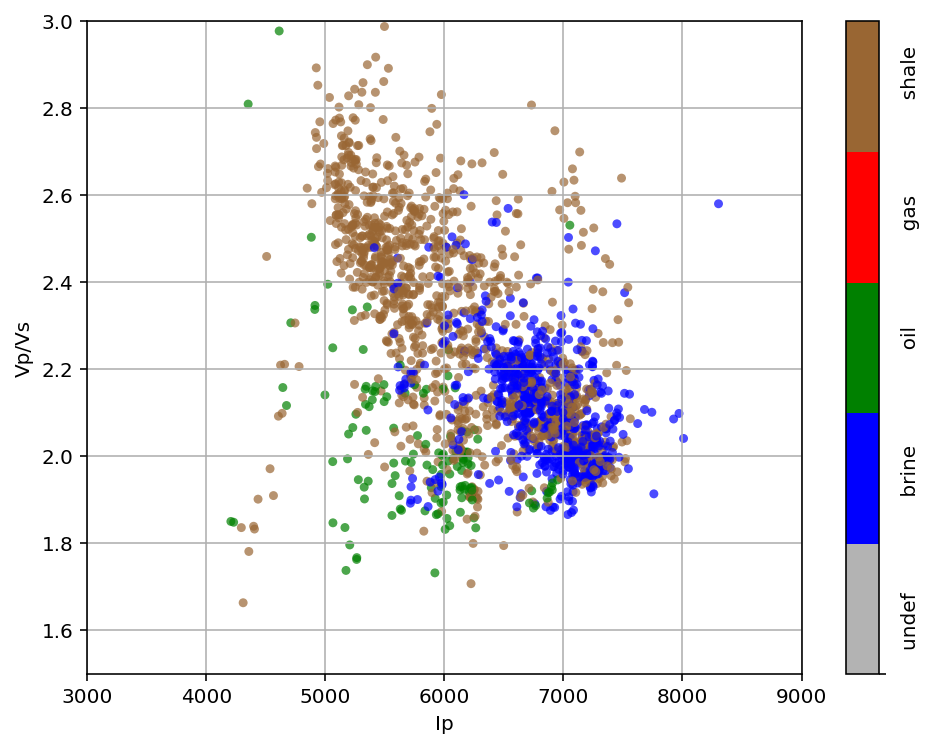

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(L.IP,L.VPVS,20,L.LFC,marker='o',edgecolors='none',alpha=0.7,cmap=cmap_facies,vmin=0,vmax=4)
plt.xlim(3000,9000); plt.ylim(1.5,3); plt.grid(); plt.xlabel('Ip'); plt.ylabel('Vp/Vs')
cbar=plt.colorbar()
cbar.set_label((15*' ').join(['undef', 'brine', 'oil', 'gas', 'shale']))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
#-----------------------------------------------------------------
#-- alternative way to label the colorbar:
#cbar.set_label('0=undef,1=brine,2=oil,3=gas,4=shale')
#cbar.set_ticks(range(0,4+1)); cbar.set_ticklabels(range(0,4+1));
#-----------------------------------------------------------------
cbar.set_alpha(1)
cbar.draw_all()

What about that red color in the legend plot above? Well, that was reserved for gas sands -- but we don't have any in the insitu case. Let's go make some of those!

## fluid replacement modeling

Fluid replacement modeling (FRM in short), based on Gassmann's equation, is one of the key activities for any kind of quantitative work (see Wang, 2001 and Smith et al., 2003, for an exhaustive overview).

It is used to model the response of elastic logs (i.e., Vp, Vs and density) in different fluid conditions, thus allowing to study how much a rock would change in terms of velocity (or impedances) if it was filled with gas instead of brine for example; but what it also does is to bring all elastic logs to a *common fluid denominator* to focus only on lithological variations, disregarding fluid effects.

The inputs to FRM are $k_s$ and $\mu_s$ (saturated bulk and shear moduli which we can get from recorded Vps, Vs and density logs), $k_d$ and $\mu_d$ (dry-rock bulk and shear moduli), $k_0$ (mineral bulk modulus), $k_f$ (fluid bulk modulus) and porosity, $\varphi$. Reasonable estimates of mineral and fluid bulk moduli and porosity are easily computed and are shown below. The real unknowns, what is arguably the core issue of rock physics, are the dry-rock moduli.

And here we come to Gassmann's equation; I can use it in its inverse form to calculate $k_d$:

$$ k_d = \frac{k_s \cdot ( \frac{\varphi k_0}{k_f} +1-\varphi) -k_0}{\frac {\varphi k_0}{k_f} + \frac{k_s}{k_0} -1-\varphi} $$

Then I use Gassmann's again in its direct form to calculate the saturated bulk modulus with the new fluid:

$$k_s = k_d + \frac { (1-\frac{k_d}{k_0})^2} { \frac{\varphi}{k_f} + \frac{1-\varphi}{k_0} - \frac{k_d}{k_0^2}}$$

Shear modulus is not affected by pore fluid so that it stays unmodified throughout the fluid replacement process.

$$\mu_s = \mu_d$$

Bulk density is defined via the following equation:

$$\rho = (1-\varphi) \cdot \rho_0 + \varphi \cdot \rho_f $$

And this is how I define it all as a Python function:

In [21]:
def gassmann(vp1, vs1, rho1, rho_fl1, k_fl1, rho_fl2, k_fl2, k0, phi):
    vp1=vp1/1000
    vs1=vs1/1000
    rho2 = rho1-phi*rho_fl1+phi*rho_fl2
    mu1 = rho1*vs1**2.
    k1 = rho1*vp1**2-(4./3.)*mu1
    kdry= (k1 * ((phi*k0)/k_fl1+1-phi)-k0) / ((phi*k0)/k_fl1+(k1/k0)-1-phi)
    k2 = kdry + (1- (kdry/k0))**2 / ( (phi/k_fl2) + ((1-phi)/k0) - (kdry/k0**2) )
    mu2 = mu1
    vp2 = np.sqrt(((k2+(4./3)*mu2))/rho2)
    vs2 = np.sqrt((mu2/rho2))
    return [vp2*1000, vs2*1000, rho2, k2]

What this function does is to get the relevant inputs which are:

* `vp1`, `vs1`, `rho1`: measured Vp, Vs, and density (saturated with fluid 1)
* `rho_fl1`, `k_fl1`: density and bulk modulus of fluid 1
* `rho_fl2`, `k_fl2`: density and bulk modulus of fluid 2
* `k0`: mineral bulk modulus
* `phi`:  porosity

And returns `vp2`,`vs2`, `rho2`, `k2` which are respectively Vp, Vs, density and bulk modulus of rock with fluid 2.

I have mentioned above the possibility to get estimates of mineral bulk modulus $k_0$; the thing to know is that another assumption in Gassmann's equation is that it works only on monomineralic rocks; an actual rock is always a mixture of different minerals. A good approximation to get a mixed mineralogy bulk modulus `k0` is to use Voigt-Reuss-Hill averaging (check [these notes](https://pangea.stanford.edu/courses/gp262/Notes/9.EffectiveMediumTheories.pdf) by [Jack Dvorkin](http://pangea.stanford.edu/~jack/) for a more rigorous discussion or [this wikipedia entry](http://en.wikipedia.org/wiki/Rule_of_mixtures)).

So I code another function, `vrh`, to do that:

In [22]:
def vrh(volumes,k,mu):
    f=np.array(volumes).T
    k=np.resize(np.array(k),np.shape(f))
    mu=np.resize(np.array(mu),np.shape(f))
    ax = 0 if f.ndim==1 else 1
    k_u = np.sum(f*k,axis=ax)
    k_l = 1./np.sum(f/k,axis=ax)
    mu_u = np.sum(f*mu,axis=ax)
    with np.errstate(divide='ignore', invalid='ignore'):
        mu_l = 1./np.sum(f/mu,axis=ax)
    k0 = (k_u+k_l)/2.
    mu0 = (mu_u+mu_l)/2.
    return k_u, k_l, mu_u, mu_l, k0, mu0

I can use the same function to also compute the fluid bulk modulus log which is usually done via Reuss average (the lower bound `k_l` in the `vrh` function above):

First I need to define the various mineral and fluid elastic constants:

In [23]:
rho_qz=2.65;  k_qz=37;  mu_qz=44    # mineral properties, quartz (i.e., sands)
rho_sh=2.81;  k_sh=15;  mu_sh=5     # mineral properties, clay (i.e., shales)
rho_b=1.09;   k_b=2.8               # fluid properties, brine
rho_o=0.78;   k_o=0.94              # fluid properties, oil
rho_g=0.25;   k_g=0.06              # fluid properties, gas

Then I  calculate the original (insitu) fluid density `rho_fl` and bulk modulus `k_fl`, and the average mineral bulk modulus `k0`:

In [24]:
# mineral mixture bulk and shear moduli, k0 and mu0
shale=L.VSH.values
sand=1-shale-L.PHIE.values
shaleN = shale/(shale+sand)  # normalized shale and sand volumes
sandN  = sand/(shale+sand)
[k_u, k_l, mu_u, mu_l, k0, mu0]=vrh([shaleN, sandN],[k_sh,k_qz],[mu_sh,mu_qz])

# fluid mixture bulk modulus, using the same vrh function but capturing the Reuss average (second output)
water=L.SWE.values
hc=1-L.SWE.values
[tmp, k_fl, tmp, tmp, tmp, tmp]=vrh([water, hc],[k_b,k_o],[0,0])

# fluid mixture density
rho_fl=water*rho_b + hc*rho_o

...and put it all together using the `frm` function defined above:

In [25]:
[vpb, vsb, rhob, kb]=gassmann(L.VP, L.VS, L.RHO, rho_fl, k_fl, rho_b, k_b, k0, L.PHIE)
[vpo, vso, rhoo, ko]=gassmann(L.VP, L.VS, L.RHO, rho_fl, k_fl, rho_o, k_o, k0, L.PHIE)
[vpg, vsg, rhog, kg]=gassmann(L.VP, L.VS, L.RHO, rho_fl, k_fl, rho_g, k_g, k0, L.PHIE)

Now I create 3 sets of copies of the original elastic logs stored in my DataFrame `L` (`L.VP`, `L.VSB`, `L.RHO`) for the three fluid scenarios investigated (and I will append an appropriate suffix to identify these 3 cases, i.e. `_FRMB` for brine, `_FRMG` for gas and `_FRMO` for oil, respectively).

These three sets will be placeholders to store the values of the actual fluid-replaced logs (`vpb`, `vsb`, `rhob`, etc.).

The syntax I use to do this is:

    L['VP_FRMB'][ssb|sso]=vpb[ssb|sso]
    
Which means, copy the values from the output of fluid replacement (`vpb`, `vsb`, `rhob`, etc.) only where there's sand (`vpb[ssb|sso]`), i.e. only when either the flag logs `ssb` or `sso` are _True_).

I also compute the additional elastic logs (acoustic and shear impedances `IP`, `Is`, and Vp/Vs ratio, `VPVS`) in their fluid-replaced version.

In [26]:
L['VP_FRMB']=L.VP
L['VS_FRMB']=L.VS
L['RHO_FRMB']=L.RHO
L['VP_FRMB'][ssb|sso]=vpb[ssb|sso]
L['VS_FRMB'][ssb|sso]=vsb[ssb|sso]
L['RHO_FRMB'][ssb|sso]=rhob[ssb|sso]
L['IP_FRMB']=L.VP_FRMB*L.RHO_FRMB
L['IS_FRMB']=L.VS_FRMB*L.RHO_FRMB
L['VPVS_FRMB']=L.VP_FRMB/L.VS_FRMB

L['VP_FRMO']=L.VP
L['VS_FRMO']=L.VS
L['RHO_FRMO']=L.RHO
L['VP_FRMO'][ssb|sso]=vpo[ssb|sso]
L['VS_FRMO'][ssb|sso]=vso[ssb|sso]
L['RHO_FRMO'][ssb|sso]=rhoo[ssb|sso]
L['IP_FRMO']=L.VP_FRMO*L.RHO_FRMO
L['IS_FRMO']=L.VS_FRMO*L.RHO_FRMO
L['VPVS_FRMO']=L.VP_FRMO/L.VS_FRMO

L['VP_FRMG']=L.VP
L['VS_FRMG']=L.VS
L['RHO_FRMG']=L.RHO
L['VP_FRMG'][ssb|sso]=vpg[ssb|sso]
L['VS_FRMG'][ssb|sso]=vsg[ssb|sso]
L['RHO_FRMG'][ssb|sso]=rhog[ssb|sso]
L['IP_FRMG']=L.VP_FRMG*L.RHO_FRMG
L['IS_FRMG']=L.VS_FRMG*L.RHO_FRMG
L['VPVS_FRMG']=L.VP_FRMG/L.VS_FRMG

Finally, I will add three more LFC logs that will be companions to the new fluid-replaced logs. 

The LFC log for brine-replaced logs will be always 1 whenever there's sand, because fluid replacement will have acted on all sand points and replaced whatever fluid we had originally with brine. Same thing for `LFC_O` and `LFC_G` (LFC for oil and gas-replaced logs): they will always be equal to 2 (oil) or 3 (gas) for all the sand samples. That translates into Python like:

In [27]:
temp_lfc_b=np.zeros(np.shape(L.VSH))
temp_lfc_b[ssb.values | sso.values]=1  # LFC is 1 when either ssb (brine sand flag) or sso (oil) is True
temp_lfc_b[sh.values]=4                # LFC 4=shale
L['LFC_B']= temp_lfc_b

temp_lfc_o=np.zeros(np.shape(L.VSH))
temp_lfc_o[ssb.values | sso.values]=2  # LFC is now 2 when there's sand (ssb or sso is True)
temp_lfc_o[sh.values]=4                # LFC 4=shale
L['LFC_O']= temp_lfc_o

temp_lfc_g=np.zeros(np.shape(L.VSH))
temp_lfc_g[ssb.values | sso.values]=3  # LFC 3=gas sand
temp_lfc_g[sh.values]=4                # LFC 4=shale
L['LFC_G']= temp_lfc_g

And this is the same summary plot that I have used above, updated to show the fluid changes in the elastic logs Ip and Vp/Vs. It is also zoomed into the reservoir between 2150 and 2200 m, and the LFC log is the original one, i.e. it reflects the insitu case.

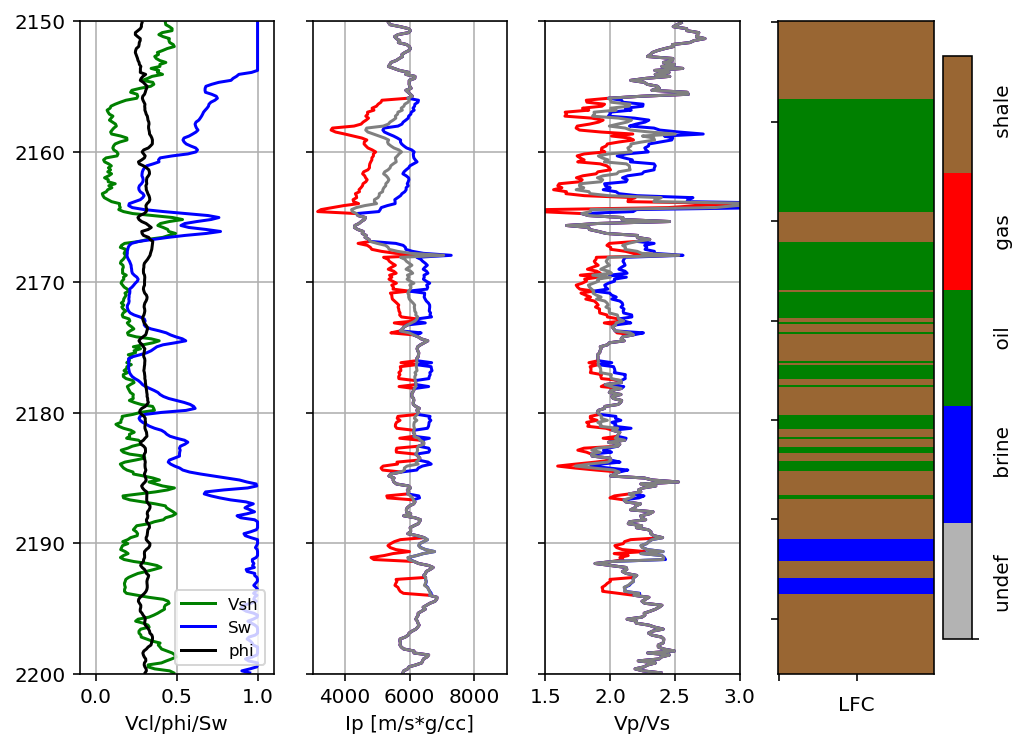

In [28]:
ztop=2150; zbot=2200
ll=L[(L.index>=ztop) & (L.index<=zbot)]

cluster=np.repeat(np.expand_dims(ll['LFC'].values,1),100,1)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 6))
ax[0].plot(ll.VSH, ll.index, '-g', label='Vsh')
ax[0].plot(ll.SWE, ll.index, '-b', label='Sw')
ax[0].plot(ll.PHIE, ll.index, '-k', label='phi')
ax[1].plot(ll.IP_FRMG, ll.index, '-r')
ax[1].plot(ll.IP_FRMB, ll.index, '-b')
ax[1].plot(ll.IP, ll.index, '-', color='0.5')
ax[2].plot(ll.VPVS_FRMG, ll.index, '-r')
ax[2].plot(ll.VPVS_FRMB, ll.index, '-b')
ax[2].plot(ll.VPVS, ll.index, '-', color='0.5')
im=ax[3].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=4)
cbar=plt.colorbar(im, ax=ax[3])
# cbar.set_label('0=undef,1=brine,2=oil,3=gas,4=shale')
# cbar.set_ticks(range(0,4+1)); 
cbar.set_label((12*' ').join(['undef', 'brine', 'oil', 'gas', 'shale']))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
for i in ax[:-1]:
    i.set_ylim(ztop,zbot)
    i.invert_yaxis()
    i.grid()
    i.locator_params(axis='x', nbins=4)
ax[0].legend(fontsize='small', loc='lower right')
ax[0].set_xlabel('Vcl/phi/Sw'),    ax[0].set_xlim(-.1,1.1)
ax[1].set_xlabel('Ip [m/s*g/cc]'), ax[1].set_xlim(3000,9000)
ax[2].set_xlabel('Vp/Vs'),         ax[2].set_xlim(1.5,3)
ax[3].set_xlabel('LFC')
ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([]); ax[3].set_xticklabels([]);

Let's have a look at the results in the Ip versus Vp/Vs crossplot domain; I will now plot 4 different plots to compare the initial situation to the results of the 4 fluid replacements:

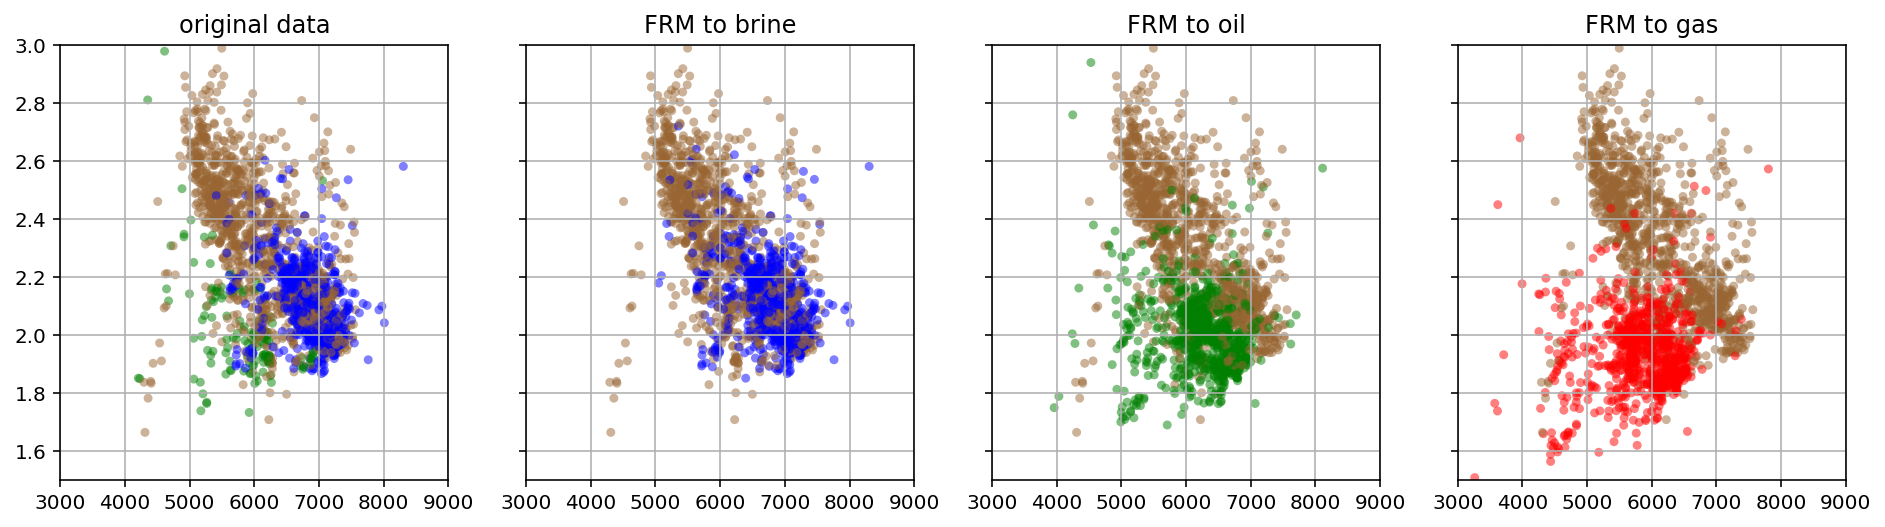

In [29]:
f, ax = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(16, 4))
ax[0].scatter(L.IP,L.VPVS,20,L.LFC,marker='o',edgecolors='none',alpha=0.5,cmap=cmap_facies,vmin=0,vmax=4)
ax[1].scatter(L.IP_FRMB,L.VPVS_FRMB,20,L.LFC_B,marker='o',edgecolors='none',alpha=0.5,cmap=cmap_facies,vmin=0,vmax=4)
ax[2].scatter(L.IP_FRMO,L.VPVS_FRMO,20,L.LFC_O,marker='o',edgecolors='none',alpha=0.5,cmap=cmap_facies,vmin=0,vmax=4)
ax[3].scatter(L.IP_FRMG,L.VPVS_FRMG,20,L.LFC_G,marker='o',edgecolors='none',alpha=0.5,cmap=cmap_facies,vmin=0,vmax=4)
ax[0].set_xlim(3000,9000); ax[0].set_ylim(1.5,3);
ax[0].set_title('original data');
ax[1].set_title('FRM to brine');
ax[2].set_title('FRM to oil');
ax[3].set_title('FRM to gas');
for i in ax: i.grid()

## statistical analysis

### generalities

Through FRM I have created an _extended_ dataset. What I want to do now is a further abstraction, moving away from the intricacies and local irregularities of the real data with the goal of creating a fully synthetic dataset representing an idealized version of a reservoir.

The first step is to study some basic statistical properties, i.e. [tendency](http://en.wikipedia.org/wiki/Central_tendency), [dispersion](http://en.wikipedia.org/wiki/Statistical_dispersion) and [correlation](http://en.wikipedia.org/wiki/Correlation_and_dependence) between certain elastic properties for each litho-fluid class.

Central tendency is simply described by calculating the mean values of some desired elastic property for all the existing classes; dispersion and correlation are summarised with the _covariance matrix_, which can be written like this (for two generic variables X and Y):

    [ var_X     cov_XY ]
    [ cov_XY    var_Y  ]

if I had _three_ variables instead:

    [ var_X     cov_XY    cov_XZ ]
    [ cov_XY    var_Y     cov_YZ ]
    [ cov_XZ    cov_YZ    var_Z  ]

Where `var_X` is the [variance](http://en.wikipedia.org/wiki/Variance) of property X, i.e. a measure of dispersion about the mean, while the [covariance](http://en.wikipedia.org/wiki/Covariance) `cov_XY` is a measure of similarity between two properties X and Y. A detailed description of the covariance matrix can be found at [this wikipedia entry](http://en.wikipedia.org/wiki/Covariance_matrix).

Python allows me to easily perform these calculations; the covariance matrix will be stored 'flattened' to make it easily accessible even if it has redundancies s(e.g. `cov_XY` in the 2-variable scenario):

    [var_X   cov_XY   cov_XY   var_Y]

### implementation in python

For the rest of this exercise I will work with the two variables used so far, i.e. Ip and Vp/Vs.

First I need to prepare a few things to make the procedure easily extendable to other situations (e.g., using more than two variables):

1. collect all the insitu and fluid-replaced logs together to create a _megalog_;
2. create a Pandas DataFrame to hold statistical information for all the litho-fluid classes.

To create a megalog (step 1) I use the following code:

In [30]:
lognames0=['LFC','IP','VPVS']
lognames1=['LFC_B','IP_FRMB', 'VPVS_FRMB']
lognames2=['LFC_O','IP_FRMO', 'VPVS_FRMO']
lognames3=['LFC_G','IP_FRMG', 'VPVS_FRMG']

ww0=L[pd.notnull(L.LFC)][lognames0].values
ww1=L[pd.notnull(L.LFC)][lognames1].values
ww2=L[pd.notnull(L.LFC)][lognames2].values
ww3=L[pd.notnull(L.LFC)][lognames3].values

ww=pd.DataFrame(np.vstack((ww0,ww1,ww2,ww3)), columns=lognames0)

What I have done here is to first define 4 lists containing the names of the logs I need. Then I extract into 4 separate temporary DataFrames that are automatically converted to simple Numpy arrays (with `.values`) different sets of logs. For example, `ww0` contains only the `LFC`,`IP`,`VPVS`, while `ww1` contains only `LFC_B`,`IP_FRMB`, `VPVS_FRMB`.

I then merge the 4 datasets together and convert it back to a Pandas DataFrame assigning as column names `LFC`,`IP`,`VPVS` (at this point, I treat all samples the same regardless of whether they were the insitu values or the fluid-replaced ones).

In other words, I have created a megalog (`ww`) that includes all values of Ip and Vp/Vs that are both measured for a certain facies, and synthetically created through fluid substitution.

For step 2 first I build the headers for a Pandas DataFrame to store mean and covariances for each class:

In [31]:
nlfc=int(ww.LFC.max())
nlogs=len(ww.columns)-1    # merged data always contain a facies log so total number of logs is 3-1
names_mean=['']*nlogs      # create empty list of strings for the mean columns header
names_cov=['']*nlogs**2   # same as above but for the covariance columns
for i,aa in enumerate(names_mean):  # populate names_mean with unique names
    names_mean[i]='mean'+str(i)
for i,aa in enumerate(names_cov):   # populate names_cov with unique names
    names_cov[i]='c'+str(i)        

I will now create a DataFrame which is dynamically dimensioned and made of `nfacies` rows, i.e. one row per each facies, and `1+n+m+1` columns, where `n` is the number of columns with the mean values of Ip and Vp/Vs, `m` is the length of the flattened covariance matrix. In this example where we have only two properties this means:

* 1 column to store the facies number (`LFC`)
* 2 columns to store mean values (`mean0` and `mean1`)
* 4 columns to store flattened covariance matrices(`c0` is the variance of Ip, `c1` and `c2` will be the covariance Ip-Vp/Vs and they will be equal, `c3` is the variance of Vp/Vs)
* 1 column to store the number of samples belonging to each facies (`SAMPLES`)

In [32]:
stat=pd.DataFrame(data=None,
    columns=['LFC']+names_mean+names_cov+['SAMPLES'],
    index=np.arange(nlfc))
stat['LFC']=range(1,nlfc+1)

This is how the `stat` DataFrame looks like now:

In [33]:
stat

,LFC,mean0,mean1,c0,c1,c2,c3,SAMPLES
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To recap: right now I just have an empty box, made of four rows (because we have 4 classes: shale, brine, oil and gas sands), and for each row we have 2 columns to store the averages of property n.1 (Ip) and n.2 (Vp/Vs), 4 columns to store the flattened covariance matrices and finally 1 column with the number of samples for each class (that will inform me on the robustness of the analysis, i.e. if I have too few samples then I need to consider how my statistical analysis will not be reliable).

The following snippet shows how to populate `stat` and prints out the number of samples in each class; also note the use of `.flatten()` at line 5 that linearize the covariance matrix as discussed above:

In [34]:
for i in range(1,nlfc+1):
    temp=ww[ww.LFC==i].drop('LFC',1)
    stat.loc[stat.LFC==i,'SAMPLES']=temp.count()[0]
    stat.loc[stat.LFC==i,names_mean[0]:names_mean[-1]]=np.mean(temp.values,0)
    stat.loc[stat.LFC==i,names_cov[0]:names_cov[-1]]=np.cov(temp,rowvar=0).flatten()
    print('LFC={}, number of samples={}'.format(i, temp.count()[0]))

LFC=1, number of samples=1546
LFC=2, number of samples=974
LFC=3, number of samples=840
LFC=4, number of samples=4512


Now let's look back at `stat` and see how it has been filled up with all the information I need:    

In [35]:
stat

,LFC,mean0,mean1,c0,c1,c2,c3,SAMPLES
0,1,6790.21,2.11403,199721,-27.9541,-27.9541,0.0205225,1546
1,2,6184.98,2.00664,337593,-16.7249,-16.7249,0.0234101,974
2,3,5816.3,1.939,360001,8.66782,8.66782,0.020416,840
3,4,6087.85,2.31668,492525,-98.0249,-98.0249,0.0562869,4512


I can also interrogate `stat` to know for example the average Ip for the litho-fluid class 1 (brine sands):

In [36]:
stat[stat.LFC==1]['mean0']

0    6790.21
Name: mean0, dtype: object

or the variance of Vp/Vs for class 2:

In [37]:
stat[stat.LFC==1]['c3']

0    0.0205225
Name: c3, dtype: object

Obviously I need to remember that the _first_ property is Ip, so that's why I am querying the column `mean0` (`mean1` contains the mean values for the _second_ property, in this case Vp/Vs). I could have named in a different way the columns just to avoid any confusion, agreed.

Remember that Python works with zero-based lists and vectors, so the first one has always an index of 0. If I were working with 3 properties, e.g. Ip, Vp/Vs and density, then the average density value for a hypothetical class 5 would be: `stat[stat.LFC==5]['mean2']`; 

To display graphically the same information and compare brine sands (class 1) with gas sands (class 3) I use Pandas' `scatter_matrix`:

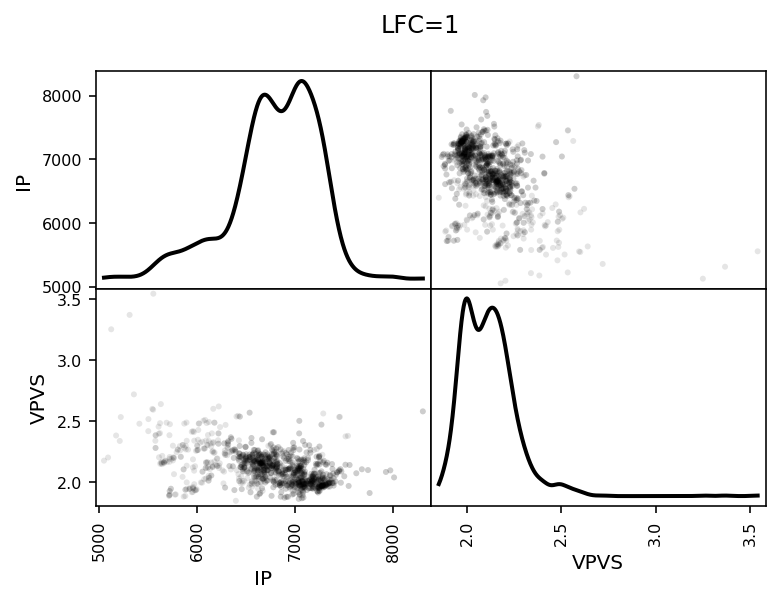

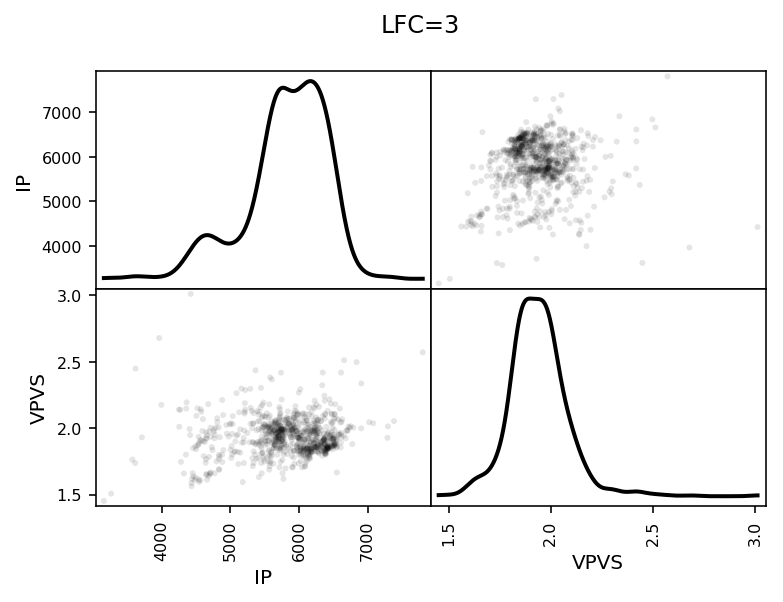

In [39]:
i=1
for i in [1,3]:
    pd.plotting.scatter_matrix(ww[ww.LFC==i].drop('LFC',1), color='black', diagonal='kde', alpha=0.1, density_kwds={'color':'#000000','lw':2})
    plt.suptitle('LFC=%d' % i)

## creation of synthetic datasets

I can now use all this information to create a brand new synthetic dataset that will replicate the average behaviour of the reservoir complex and at the same time overcome typical problems when using real data like undersampling of a certain class, presence of outliers, spurious occurrence of anomalies.

To create the synthetic datasets I use a Monte Carlo simulation relying on [multivariate normal distribution](http://en.wikipedia.org/wiki/Multivariate_normal_distribution) to draw samples that are random but correlated in the elastic domain of choice (Ip and Vp/Vs).

This is the code:

In [43]:
NN=300

mc=pd.DataFrame(data=None,
    columns=lognames0,
    index=np.arange(nlfc*NN), dtype='float')

for i in range(1,nlfc+1):
    mc.loc[NN*i-NN:NN*i-1,'LFC']=i

First I define how many samples per class I want, then I create an empty Pandas DataFrame with these specs:

* as many columns as the elastic logs I have chosen: in this case, 3 (`LFC`, `IP` and `VPVS`, stored in `lognames0`, previously used to dimension the `stat` DataFrame);
* the total number of rows will be equal to number of samples (e.g., 100) multiplied by the number of classes (4).

Finally, I fill in the `LFC` column with the numbers assigned to each class. I use the `nlfc` variable that contains the total number of classes, introduced earlier when creating the `stat` DataFrame; then I loop over the range 1 to `nlfc` , and assign 1 to rows 1-299, 2 to 300-599, and so on.

The next code snippet is at the core of the entire procedure.

In [65]:
for i in range(1,nlfc+1):
    mean =             stat.loc[i-1,names_mean[0]:names_mean[-1]].values.astype(np.float32, copy=False)
    sigma = np.reshape(stat.loc[i-1,names_cov[0]:names_cov[-1]].values,(nlogs,nlogs)).astype(np.float32, copy=False)
#     print('class {}: mean={}, sigma={}'.format(i,mean,sigma))
    mc.loc[mc.LFC==i,1:] = np.random.multivariate_normal(mean,sigma,NN,check_valid='ignore')

For each class (another loop over the range 1-`nlfc`) I extract the average value `mean` and the covariance matrix `sigma` from the `stat` DataFrame, then put them into the [Numpy `np.random.multivariate_normal` ](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html) method to draw randomly selected samples from the continuous and correlated distributions of the properties Ip and Vp/Vs.

So the `mc` DataFrame is now made of 3 columns (`LFC`, `IP`, `VPVS`) and 1200 rows:

In [66]:
mc.describe()

,LFC,IP,VPVS
count,1200.0000,1200.000000,1200.000000
mean,2.5000,6265.112630,2.100294
std,1.1185,661.104336,0.217301
min,1.0000,4299.261056,1.548199
25%,1.7500,5787.597321,1.950863
50%,2.5000,6288.131324,2.074322
75%,3.2500,6759.082611,2.230949
max,4.0000,7992.950163,2.914140


And these are the results, comparing the original, augmented dataset (i.e. the results of fluid replacement merged with the insitu log, all stored in the DataFrame `ww` defined earlier when calculating the statistics) with the newly created synthetic data:

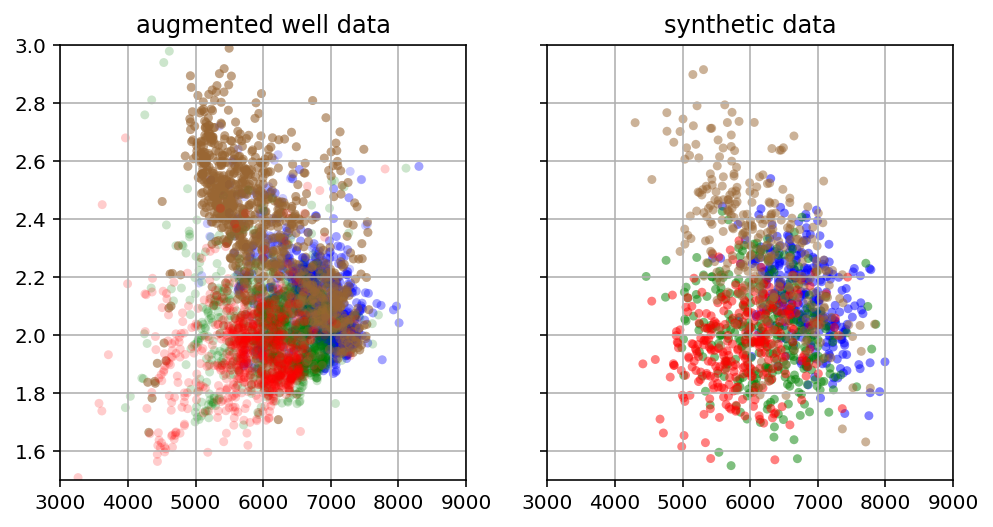

In [67]:
f, ax = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(8, 4))
scatt1=ax[0].scatter(ww.IP,ww.VPVS,20,ww.LFC,marker='o',edgecolors='none', alpha=0.2, cmap=cmap_facies,vmin=0,vmax=4)
scatt2=ax[1].scatter(mc.IP,mc.VPVS,20,mc.LFC,marker='o',edgecolors='none', alpha=0.5, cmap=cmap_facies,vmin=0,vmax=4)
ax[0].set_xlim(3000,9000); ax[0].set_ylim(1.5,3.0);
ax[0].set_title('augmented well data');
ax[1].set_title('synthetic data');
for i in ax: i.grid()

## go interactive !

One very cool feature of these IPython notebooks, is the possibility to go interactive. I have created a [separate notebook](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_petrophysics_interactive.ipynb)  available for download in the repository <https://github.com/aadm/geophysical_notes>

## references

* Avseth, P., Mukerji, T. & Mavko, G. Quantitative Seismic Interpretation. (Cambridge University Press, 2005).
* Chambers, R., Yarus, J. & Hird, K. Petroleum geostatistics for nongeostatisticians - Part 1. The Leading Edge (2000).
* Mavko, G., Mukerji, T. & Dvorkin, J. The Rock Physics Handbook. (Cambridge University Press, 2009).
* Mukerji, T., Avseth, P., Mavko, G., Takahashi, I. & González, E. F. Statistical rock physics : Combining rock physics , information theory , and geostatistics to reduce uncertainty in seismic reservoir characterization. The Leading Edge 313–319 (2001).
* Smith, T. M., Sondergeld, C. H. & Rai, C. S. Gassmann fluid substitutions : A tutorial. Geophysics 68, 430–440 (2003).
* Wang, Z. Z. Fundamentals of seismic rock physics. Geophysics 66, 398–412 (2001).

See also the awesome collection of tutorials curated by Matt Hall for [The Leading Edge](http://library.seg.org/journal/leedff) and available here: <https://github.com/seg/tutorials>